# Description

Notebook for custom sklearn wrappers for exclusion threshold classifier.

# Imports

In [1]:
%load_ext autoreload
%autoreload

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from linearmodels.iv import IV2SLS

# Common issue with glibc, scikit (?), where the number of libraries loaded with static TLS is limited
# Can only load one of econml or rpy2...
# e.g. https://github.com/pytorch/pytorch/issues/2575#issuecomment-523657178
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

# user imports
sys.path.append("../")

# Don't import iv_power for now since it needs rpy2
from utils.pwr import rdd_power
from utils.sim import generate_IV_comply_indicator

# Threshold classifier wrapper

- executive decision: probably easier to just write a custom fold validation
    - problem with using sklearn gridsearchCV: would be retraining the model on the same data for each threshold tested -> slowwww

In [4]:
def iv_neff(scores, tz_df, threshold):
    """
    Computes the effective sample size of the given data sample.
    
    Args:
        scores (np.array): array of compliance scores
        tz_df (pd.DataFrame)
    
    """    
    tz_df['score'] = scores
    sel_df = tz_df[tz_df['score'] >= threshold].copy()
    
    if (sel_df[(sel_df['Z'] == 1)].shape[0] == 0) or (sel_df[(sel_df['Z'] == 0)].shape[0] == 0):
        #print("no samples!")
        return -np.inf
    
    comply_rate = sel_df[(sel_df['Z'] == 1)]['T'].mean() - sel_df[(sel_df['Z'] == 0)]['T'].mean()
    
    return sel_df.shape[0] * (comply_rate**2)

In [5]:
class ThresholdCV():
    """
    Custom CV operation to detect the best threshold.
    
    Could also be converted to an estimator to be
    nested with GridSearchCV, down the line.
    """
    default_n_thresholds = 100
    random_state = 42
    
    def __init__(self, thresholds=None, n_splits=5, clf_class=None):
        self.thresholds = thresholds
        self.n_splits = n_splits
        
        if clf_class:
            self.clf_class = clf_class
        else:
            self.clf_class = CausalForest
        
    def get_best_threshold(self, iv_df, feat_cols):
        """
        Returns the best threshold based on KFold fitting.
        
        Args:
            iv_df (pd.DataFrame): the IV data
            feat_cols (list): the list of column name features
        """
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        # each row is the neff score for all thresholds on a particular fold
        # each column holds all the fold scores for a particular threshold
        if self.thresholds is not None:
            neff_scores = np.zeros((self.n_splits, len(self.thresholds)))
        else:
            neff_scores = np.zeros((self.n_splits, self.default_n_thresholds))
        
        for split_idx, (train_idx, test_idx) in enumerate(kfold.split(iv_df)):
            # print(idx)
            # print(train_idx)
            # print(test_idx)
            train_df = iv_df.iloc[train_idx].copy()
            test_df = iv_df.iloc[test_idx].copy()
            
            # train a single classifier for a given split
            train_X = train_df[feat_cols]
            train_Y = train_df['T']
            train_T = train_df['Z']
            
            test_X = test_df[feat_cols]
            test_Y = test_df['T']
            test_T = test_df['Z']
            
            # initialize the class constructor
            clf = self.clf_class(random_state=self.random_state)
            clf.fit(X=train_X, y=train_Y, T=train_T)
            #print(clf)
            
            scores = clf.predict(test_X)
            tz_df = test_df[['T', 'Z']].copy()
            
            # go over all thresholds with fixed clf
            if self.thresholds is None:
                self.thresholds = np.linspace(np.min(scores), np.max(scores), 
                                              num=self.default_n_thresholds).flatten()
            
            #print(self.thresholds)
            
            for thres_idx, threshold in enumerate(self.thresholds):
                neff = iv_neff(scores, tz_df, threshold)
                neff_scores[split_idx, thres_idx] = neff
    
        mean_neff = np.mean(neff_scores, axis=0)
        best_threshold = self.thresholds[np.argmax(mean_neff)]
        
        assert mean_neff.shape[0] == len(self.thresholds)
        
        #print("Best neff: {:.3f}".format(np.max(mean_neff)))
        #print("Best threshold: {:.3f}".format(best_threshold))
        return best_threshold
                
    

## Make data: strong compliance

In [6]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=5, noise=0, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [7]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [8]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.42 s, sys: 561 ms, total: 4.98 s
Wall time: 3.59 s


In [9]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 149.03165057466623


In [10]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 320.45275966786295


## Make data: weak compliance

In [51]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=5, noise=75, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [52]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [53]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.43 s, sys: 545 ms, total: 4.98 s
Wall time: 3.57 s


In [54]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 142.96687864597746


In [55]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 151.99997501200036


## Make data: noise

In [16]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=0, noise=100, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [17]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [18]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.55 s, sys: 538 ms, total: 5.09 s
Wall time: 3.78 s


In [19]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 190.58600096682724


In [20]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 189.93180362278542


# Simulation

## Functions

In [21]:
def fit_predict_compliance(fit_df, pred_df, feat_cols, tau, seed=0, clf=None):
    """
    Fits a compliance model on fit_df and returns the predicted compliance scores, 
    as well as predicted threshold. Specifically uses the cross-folding neff heuristic.
    
    Args:
        fit_df (pd.DataFrame): the dataframe to fit on
        pred_df (pd.DataFrame): the dataframe to generate prediction
        feat_cols (list): the list of feature columns to consider
        tau (float): the target treatment effect
        clf (model): an EconML CATE classifier, defaults to CausalForestDML if None provided
    
    Returns:
        exclusion_threshold, acc, selected_df
    """
    
    
    fit_df = fit_df.copy()
    pred_df = pred_df.copy()
    
    X = fit_df[feat_cols]
    T = fit_df['Z']
    Y = fit_df['T']
    
    # fit on fit_df data
    if clf is None:
        clf = CausalForest(random_state=seed)
#         clf = CausalForestDML(discrete_treatment=True,
#                               cv=10, 
#                               random_state=seed)
    
    clf.fit(y=Y, # need to switch back to capital "Y" for DML estimator
            T=T,
            X=X)
    
    # predict on fit and pred_df data
    fit_df['pred_comply'] = clf.predict(X)
    pred_df['pred_comply'] = clf.predict(pred_df[feat_cols])
    #fit_df['pred_comply'] = clf.effect(X)
    #pred_df['pred_comply'] = clf.effect(pred_df[feat_cols])
    
    #acc = clf.score(X=pred_df[feat_cols], Y=pred_df['T'], T=pred_df['Z'])
    acc = np.nan
    
    
    
    # use neff cross-validated scoring target here
    threshold_clf = ThresholdCV()
    exclusion_threshold = threshold_clf.get_best_threshold(fit_df, feat_cols)
            
    sel_df = pred_df[pred_df['pred_comply'] > exclusion_threshold]

    return exclusion_threshold, acc, sel_df


def populate_iv_results(df_dict, formula, data_df, tau, data_sample, acc=np.nan, threshold=np.nan):
    """
    Runs the 2SLS estimator and populates result_dict.
    
    Args:
        df_dict (dict)
        formulat (str): the patsy regression formula to use
        data_df (pd.DataFrame): the dataframe to run over
        tau (float): target treatment effect for power calculations
        data_sample (str): the name of the data sample
        acc (float): the test accuracy of the prediction, if applicable
        threshold (float): the complier threshold cutoff, if applicable
    
    Returns:
        None, but mutates result_dict
    """
    print("data_df shape:{}".format(data_df.shape[0]))
    iv_model = IV2SLS.from_formula(formula, data_df)
    iv_results = iv_model.fit(cov_type='robust')
    df_dict['tau_hat_{}'.format(data_sample)].append(iv_results.params['T'])
    df_dict['std_err_{}'.format(data_sample)].append(iv_results.std_errors['T'])
    df_dict['pwr_{}'.format(data_sample)].append(rdd_power(tau,iv_results.std_errors['T']**2))
    df_dict['n_incl_{}'.format(data_sample)].append(data_df.shape[0])
    df_dict['test_acc_{}'.format(data_sample)].append(acc)
    df_dict['threshold_{}'.format(data_sample)].append(threshold)
    

def simulate_optimal_exclusion(n_trials, clf=None, **kwargs):
    """
    Simulates optimal exclusion procedure with K=2 cross-fitting/sample splitting.
    
    Args:
        n_trials (int): number of trials to run
        clf (econml.DML): the compliance estimator to use
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['full_simple', 'full_covar', 's1_simple', 's2_simple', 's1_s2_simple']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in range(n_trials):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        # simple model with full data
        populate_iv_results(df_dict, simple_formula, fuzzy_df, kwargs['tau'], 'full_simple')

        # covariate model with full data
        populate_iv_results(df_dict, extended_formula, fuzzy_df, kwargs['tau'], 'full_covar')
        
        # split sample, TODO think about whether we need to stratified split on T
        np.random.seed(trial)
        
        kfold = StratifiedKFold(n_splits=2,
             shuffle=True, random_state=trial)

        indices = []

        for train_idx, test_idx in kfold.split(fuzzy_df, y=fuzzy_df['T']):
            indices.append(test_idx)
    

        fit_df = fuzzy_df.iloc[indices[0]].copy()
        s2_df = fuzzy_df.iloc[indices[1]].copy()

        # fit on first half
        s1_threshold, s1_acc, s1_sel_df = fit_predict_compliance(fit_df, s2_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s1_sel_df, kwargs['tau'], 's1_simple',
                            threshold=s1_threshold, acc=s1_acc)

        # fit on second half
        s2_threshold, s2_acc, s2_sel_df = fit_predict_compliance(s2_df, fit_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s2_sel_df, kwargs['tau'], 's2_simple',
                            threshold=s2_threshold, acc=s2_acc)

        
        # fit on union of excluded samples
        populate_iv_results(df_dict, simple_formula, s1_sel_df.append(s2_sel_df), kwargs['tau'], 's1_s2_simple')

        df_dict['trial'].append(trial)
        print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [22]:
def run_full_simulation(n_trials, prop_complys, sim_dict, out_name):
    """
    Runs end-to-end the simulation for Figure 3.
    """
    for prop_comply in prop_complys:
        # equal proportion of never takers and always takers
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        sim_dict['prop_at'] = p_at
        sim_dict['prop_nt'] = p_nt

        result_df = simulate_optimal_exclusion(n_trials, **sim_dict)

        result_df['data_driven_tau'] = (result_df['tau_hat_s1_simple'] + result_df['tau_hat_s2_simple']) / 2
        
        # from law of total variance
        result_df['data_driven_var'] = ((result_df['std_err_s1_simple'] ** 2) + (result_df['std_err_s2_simple'] ** 2) + \
                                     (result_df['tau_hat_s1_simple'] - result_df['data_driven_tau'])**2 + \
                                     (result_df['tau_hat_s2_simple'] - result_df['data_driven_tau'])**2) / 2

        result_df['data_driven_std'] = np.sqrt(result_df['data_driven_var'])


        result_df['data_driven_pwr'] = result_df['data_driven_var'].apply(lambda x: rdd_power(tau, var=x))
        result_df['data_driven_n_incl'] = result_df['n_incl_s1_simple'] + result_df['n_incl_s2_simple']

        # TODO fix hardcoding
        name = "../results/{}_p_comply_{}.df".format(out_name, prop_comply)
        result_df.to_pickle(name)

In [23]:
def plot_tau_pwr(data_name, tau, p_complys):
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in p_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)

    tau_hats = pd.melt(all_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                      'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(all_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                  'pwr_s1_s2_simple'])
    std_errs = pd.melt(all_df, id_vars=[x_var], value_vars = ['std_err_full_simple', 'std_err_full_covar', 
                                                      'std_err_s1_s2_simple'])

    fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,6))
    # reproduces NACI paper figure
    #fig, (ax1, ax2) = plt.subplots(1,2, dpi=100, figsize=(10,6))

    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=ax1)
    ax1.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    ax1.set_ylabel("est. treatment effect (95% CI)")
    ax1.set_ylim(0,0.5)


    handles, labels = ax1.get_legend_handles_labels()
    new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
    #ax1.legend(handles, new_labels, bbox_to_anchor=(2.9,1))
    ax1.legend(handles, new_labels)
    #ax1.set_xlabel("Proportion compliers ")
    #ax1.set_title("Treatment effect estimates")
    # sns.barplot(data=std_errs, hue="variable", x='P(treat) jump', y="value", ax=ax2)
    # ax2.set_ylabel("standard errors")
    # ax2.get_legend().set_visible(False)

    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=ax2)#, estimator=median)
    #ax2.set_title("Statistical power")
    ax2.set_ylabel("estimated power (95% CI)")
    ax2.get_legend().set_visible(False)
    #ax2.set_xlabel("Proportion compliers (95% CI)")

## simulations and plots

In [95]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

### Strong compliance prediction simulation (replicate the original figure 3)

In [96]:
strong_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=0, 
                               n_features=5)
)

strong_out_name = "strong_comply"

In [97]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        strong_sim_dict, 
                        strong_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:130
data_df shape:223
data_df shape:353
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:190
data_df shape:207
data_df shape:397
trial 14
data_df shape:2000
data_df shape:2000
data_df shape:216
data_df shape:177
data_df shape:393
trial 15
data_df shape:2000
data_df shape:2000
data_df shape:174
data_df shape:266
data_df shape:440
trial 16
data_df shape:2000
data_df shape:2000
data_df shape:189
data_df shape:270
data_df shape:459
trial 17
data_df shape:2000
data_df shape:2000
data_df shape:220
data_df shape:182
data_df shape:402
trial 18
data_df shape:2000
data_df shape:2000
data_df shape:185
data_df shape:177
data_df shape:362
trial 19
data_df shape:2000
data_df shape:2000
data_df shape:205
data_df shape:204
data_df shape:409
trial 20
data_df shape:2000
data_df shape:2000
data_df shape:228
data_df shape:195
data_df shape:423
trial 21
data_df shape:2000
data_df shape:2000
data_df shape:220
data_df 

data_df shape:2000
data_df shape:2000
data_df shape:177
data_df shape:170
data_df shape:347
trial 94
data_df shape:2000
data_df shape:2000
data_df shape:233
data_df shape:199
data_df shape:432
trial 95
data_df shape:2000
data_df shape:2000
data_df shape:202
data_df shape:245
data_df shape:447
trial 96
data_df shape:2000
data_df shape:2000
data_df shape:204
data_df shape:298
data_df shape:502
trial 97
data_df shape:2000
data_df shape:2000
data_df shape:250
data_df shape:239
data_df shape:489
trial 98
data_df shape:2000
data_df shape:2000
data_df shape:204
data_df shape:223
data_df shape:427
trial 99
data_df shape:2000
data_df shape:2000
data_df shape:226
data_df shape:176
data_df shape:402
trial 100
data_df shape:2000
data_df shape:2000
data_df shape:225
data_df shape:232
data_df shape:457
trial 101
data_df shape:2000
data_df shape:2000
data_df shape:142
data_df shape:174
data_df shape:316
trial 102
data_df shape:2000
data_df shape:2000
data_df shape:182
data_df shape:184
data_df shape:

data_df shape:224
data_df shape:483
trial 174
data_df shape:2000
data_df shape:2000
data_df shape:190
data_df shape:232
data_df shape:422
trial 175
data_df shape:2000
data_df shape:2000
data_df shape:328
data_df shape:175
data_df shape:503
trial 176
data_df shape:2000
data_df shape:2000
data_df shape:221
data_df shape:286
data_df shape:507
trial 177
data_df shape:2000
data_df shape:2000
data_df shape:171
data_df shape:245
data_df shape:416
trial 178
data_df shape:2000
data_df shape:2000
data_df shape:207
data_df shape:305
data_df shape:512
trial 179
data_df shape:2000
data_df shape:2000
data_df shape:183
data_df shape:137
data_df shape:320
trial 180
data_df shape:2000
data_df shape:2000
data_df shape:268
data_df shape:258
data_df shape:526
trial 181
data_df shape:2000
data_df shape:2000
data_df shape:189
data_df shape:262
data_df shape:451
trial 182
data_df shape:2000
data_df shape:2000
data_df shape:193
data_df shape:232
data_df shape:425
trial 183
data_df shape:2000
data_df shape:200

data_df shape:2000
data_df shape:2000
data_df shape:292
data_df shape:284
data_df shape:576
trial 255
data_df shape:2000
data_df shape:2000
data_df shape:229
data_df shape:230
data_df shape:459
trial 256
data_df shape:2000
data_df shape:2000
data_df shape:219
data_df shape:155
data_df shape:374
trial 257
data_df shape:2000
data_df shape:2000
data_df shape:180
data_df shape:184
data_df shape:364
trial 258
data_df shape:2000
data_df shape:2000
data_df shape:194
data_df shape:190
data_df shape:384
trial 259
data_df shape:2000
data_df shape:2000
data_df shape:213
data_df shape:183
data_df shape:396
trial 260
data_df shape:2000
data_df shape:2000
data_df shape:211
data_df shape:145
data_df shape:356
trial 261
data_df shape:2000
data_df shape:2000
data_df shape:202
data_df shape:182
data_df shape:384
trial 262
data_df shape:2000
data_df shape:2000
data_df shape:235
data_df shape:188
data_df shape:423
trial 263
data_df shape:2000
data_df shape:2000
data_df shape:234
data_df shape:217
data_df 

data_df shape:186
data_df shape:202
data_df shape:388
trial 335
data_df shape:2000
data_df shape:2000
data_df shape:251
data_df shape:242
data_df shape:493
trial 336
data_df shape:2000
data_df shape:2000
data_df shape:151
data_df shape:206
data_df shape:357
trial 337
data_df shape:2000
data_df shape:2000
data_df shape:222
data_df shape:164
data_df shape:386
trial 338
data_df shape:2000
data_df shape:2000
data_df shape:197
data_df shape:243
data_df shape:440
trial 339
data_df shape:2000
data_df shape:2000
data_df shape:213
data_df shape:190
data_df shape:403
trial 340
data_df shape:2000
data_df shape:2000
data_df shape:160
data_df shape:288
data_df shape:448
trial 341
data_df shape:2000
data_df shape:2000
data_df shape:273
data_df shape:182
data_df shape:455
trial 342
data_df shape:2000
data_df shape:2000
data_df shape:233
data_df shape:185
data_df shape:418
trial 343
data_df shape:2000
data_df shape:2000
data_df shape:221
data_df shape:218
data_df shape:439
trial 344
data_df shape:2000

data_df shape:2000
data_df shape:2000
data_df shape:205
data_df shape:232
data_df shape:437
trial 416
data_df shape:2000
data_df shape:2000
data_df shape:174
data_df shape:223
data_df shape:397
trial 417
data_df shape:2000
data_df shape:2000
data_df shape:188
data_df shape:270
data_df shape:458
trial 418
data_df shape:2000
data_df shape:2000
data_df shape:196
data_df shape:329
data_df shape:525
trial 419
data_df shape:2000
data_df shape:2000
data_df shape:263
data_df shape:225
data_df shape:488
trial 420
data_df shape:2000
data_df shape:2000
data_df shape:151
data_df shape:292
data_df shape:443
trial 421
data_df shape:2000
data_df shape:2000
data_df shape:247
data_df shape:218
data_df shape:465
trial 422
data_df shape:2000
data_df shape:2000
data_df shape:258
data_df shape:222
data_df shape:480
trial 423
data_df shape:2000
data_df shape:2000
data_df shape:153
data_df shape:224
data_df shape:377
trial 424
data_df shape:2000
data_df shape:2000
data_df shape:185
data_df shape:234
data_df 

data_df shape:246
data_df shape:214
data_df shape:460
trial 496
data_df shape:2000
data_df shape:2000
data_df shape:191
data_df shape:210
data_df shape:401
trial 497
data_df shape:2000
data_df shape:2000
data_df shape:134
data_df shape:219
data_df shape:353
trial 498
data_df shape:2000
data_df shape:2000
data_df shape:223
data_df shape:231
data_df shape:454
trial 499
true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:396
data_df shape:392
data_df shape:788
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:411
data_df shape:366
data_df shape:777
trial 1
data_df shape:2000
data_df shape:2000
data_df shape:378
data_df shape:534
data_df shape:912
trial 2
data_df shape:2000
data_df shape:2000
data_df shape:343
data_df shape:391
data_df shape:734
trial 3
data_df shape:2000
data_df shape:2000
data_df shape:373
data_df shape:362
data_df shape:735
trial 4
data_df shape:2000
data_df shape:2000
data_df shape:403
data_df shape:444
data_df shape:847
trial 5
da

data_df shape:412
data_df shape:369
data_df shape:781
trial 77
data_df shape:2000
data_df shape:2000
data_df shape:424
data_df shape:414
data_df shape:838
trial 78
data_df shape:2000
data_df shape:2000
data_df shape:403
data_df shape:331
data_df shape:734
trial 79
data_df shape:2000
data_df shape:2000
data_df shape:383
data_df shape:377
data_df shape:760
trial 80
data_df shape:2000
data_df shape:2000
data_df shape:387
data_df shape:469
data_df shape:856
trial 81
data_df shape:2000
data_df shape:2000
data_df shape:439
data_df shape:469
data_df shape:908
trial 82
data_df shape:2000
data_df shape:2000
data_df shape:421
data_df shape:325
data_df shape:746
trial 83
data_df shape:2000
data_df shape:2000
data_df shape:470
data_df shape:400
data_df shape:870
trial 84
data_df shape:2000
data_df shape:2000
data_df shape:410
data_df shape:457
data_df shape:867
trial 85
data_df shape:2000
data_df shape:2000
data_df shape:471
data_df shape:450
data_df shape:921
trial 86
data_df shape:2000
data_df s

data_df shape:2000
data_df shape:2000
data_df shape:406
data_df shape:357
data_df shape:763
trial 158
data_df shape:2000
data_df shape:2000
data_df shape:539
data_df shape:349
data_df shape:888
trial 159
data_df shape:2000
data_df shape:2000
data_df shape:412
data_df shape:443
data_df shape:855
trial 160
data_df shape:2000
data_df shape:2000
data_df shape:398
data_df shape:400
data_df shape:798
trial 161
data_df shape:2000
data_df shape:2000
data_df shape:517
data_df shape:439
data_df shape:956
trial 162
data_df shape:2000
data_df shape:2000
data_df shape:371
data_df shape:388
data_df shape:759
trial 163
data_df shape:2000
data_df shape:2000
data_df shape:393
data_df shape:457
data_df shape:850
trial 164
data_df shape:2000
data_df shape:2000
data_df shape:374
data_df shape:439
data_df shape:813
trial 165
data_df shape:2000
data_df shape:2000
data_df shape:383
data_df shape:403
data_df shape:786
trial 166
data_df shape:2000
data_df shape:2000
data_df shape:343
data_df shape:357
data_df 

data_df shape:360
data_df shape:393
data_df shape:753
trial 238
data_df shape:2000
data_df shape:2000
data_df shape:435
data_df shape:404
data_df shape:839
trial 239
data_df shape:2000
data_df shape:2000
data_df shape:408
data_df shape:396
data_df shape:804
trial 240
data_df shape:2000
data_df shape:2000
data_df shape:416
data_df shape:437
data_df shape:853
trial 241
data_df shape:2000
data_df shape:2000
data_df shape:428
data_df shape:393
data_df shape:821
trial 242
data_df shape:2000
data_df shape:2000
data_df shape:520
data_df shape:467
data_df shape:987
trial 243
data_df shape:2000
data_df shape:2000
data_df shape:385
data_df shape:423
data_df shape:808
trial 244
data_df shape:2000
data_df shape:2000
data_df shape:457
data_df shape:396
data_df shape:853
trial 245
data_df shape:2000
data_df shape:2000
data_df shape:553
data_df shape:411
data_df shape:964
trial 246
data_df shape:2000
data_df shape:2000
data_df shape:480
data_df shape:423
data_df shape:903
trial 247
data_df shape:2000

data_df shape:2000
data_df shape:2000
data_df shape:438
data_df shape:437
data_df shape:875
trial 319
data_df shape:2000
data_df shape:2000
data_df shape:397
data_df shape:410
data_df shape:807
trial 320
data_df shape:2000
data_df shape:2000
data_df shape:500
data_df shape:396
data_df shape:896
trial 321
data_df shape:2000
data_df shape:2000
data_df shape:444
data_df shape:489
data_df shape:933
trial 322
data_df shape:2000
data_df shape:2000
data_df shape:453
data_df shape:367
data_df shape:820
trial 323
data_df shape:2000
data_df shape:2000
data_df shape:469
data_df shape:443
data_df shape:912
trial 324
data_df shape:2000
data_df shape:2000
data_df shape:356
data_df shape:408
data_df shape:764
trial 325
data_df shape:2000
data_df shape:2000
data_df shape:355
data_df shape:390
data_df shape:745
trial 326
data_df shape:2000
data_df shape:2000
data_df shape:360
data_df shape:402
data_df shape:762
trial 327
data_df shape:2000
data_df shape:2000
data_df shape:428
data_df shape:403
data_df 

data_df shape:348
data_df shape:361
data_df shape:709
trial 399
data_df shape:2000
data_df shape:2000
data_df shape:413
data_df shape:364
data_df shape:777
trial 400
data_df shape:2000
data_df shape:2000
data_df shape:408
data_df shape:380
data_df shape:788
trial 401
data_df shape:2000
data_df shape:2000
data_df shape:407
data_df shape:445
data_df shape:852
trial 402
data_df shape:2000
data_df shape:2000
data_df shape:420
data_df shape:462
data_df shape:882
trial 403
data_df shape:2000
data_df shape:2000
data_df shape:413
data_df shape:383
data_df shape:796
trial 404
data_df shape:2000
data_df shape:2000
data_df shape:420
data_df shape:444
data_df shape:864
trial 405
data_df shape:2000
data_df shape:2000
data_df shape:487
data_df shape:483
data_df shape:970
trial 406
data_df shape:2000
data_df shape:2000
data_df shape:389
data_df shape:394
data_df shape:783
trial 407
data_df shape:2000
data_df shape:2000
data_df shape:453
data_df shape:391
data_df shape:844
trial 408
data_df shape:2000

data_df shape:2000
data_df shape:2000
data_df shape:404
data_df shape:419
data_df shape:823
trial 480
data_df shape:2000
data_df shape:2000
data_df shape:441
data_df shape:356
data_df shape:797
trial 481
data_df shape:2000
data_df shape:2000
data_df shape:391
data_df shape:425
data_df shape:816
trial 482
data_df shape:2000
data_df shape:2000
data_df shape:427
data_df shape:467
data_df shape:894
trial 483
data_df shape:2000
data_df shape:2000
data_df shape:392
data_df shape:415
data_df shape:807
trial 484
data_df shape:2000
data_df shape:2000
data_df shape:365
data_df shape:453
data_df shape:818
trial 485
data_df shape:2000
data_df shape:2000
data_df shape:416
data_df shape:449
data_df shape:865
trial 486
data_df shape:2000
data_df shape:2000
data_df shape:426
data_df shape:406
data_df shape:832
trial 487
data_df shape:2000
data_df shape:2000
data_df shape:357
data_df shape:383
data_df shape:740
trial 488
data_df shape:2000
data_df shape:2000
data_df shape:470
data_df shape:505
data_df 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



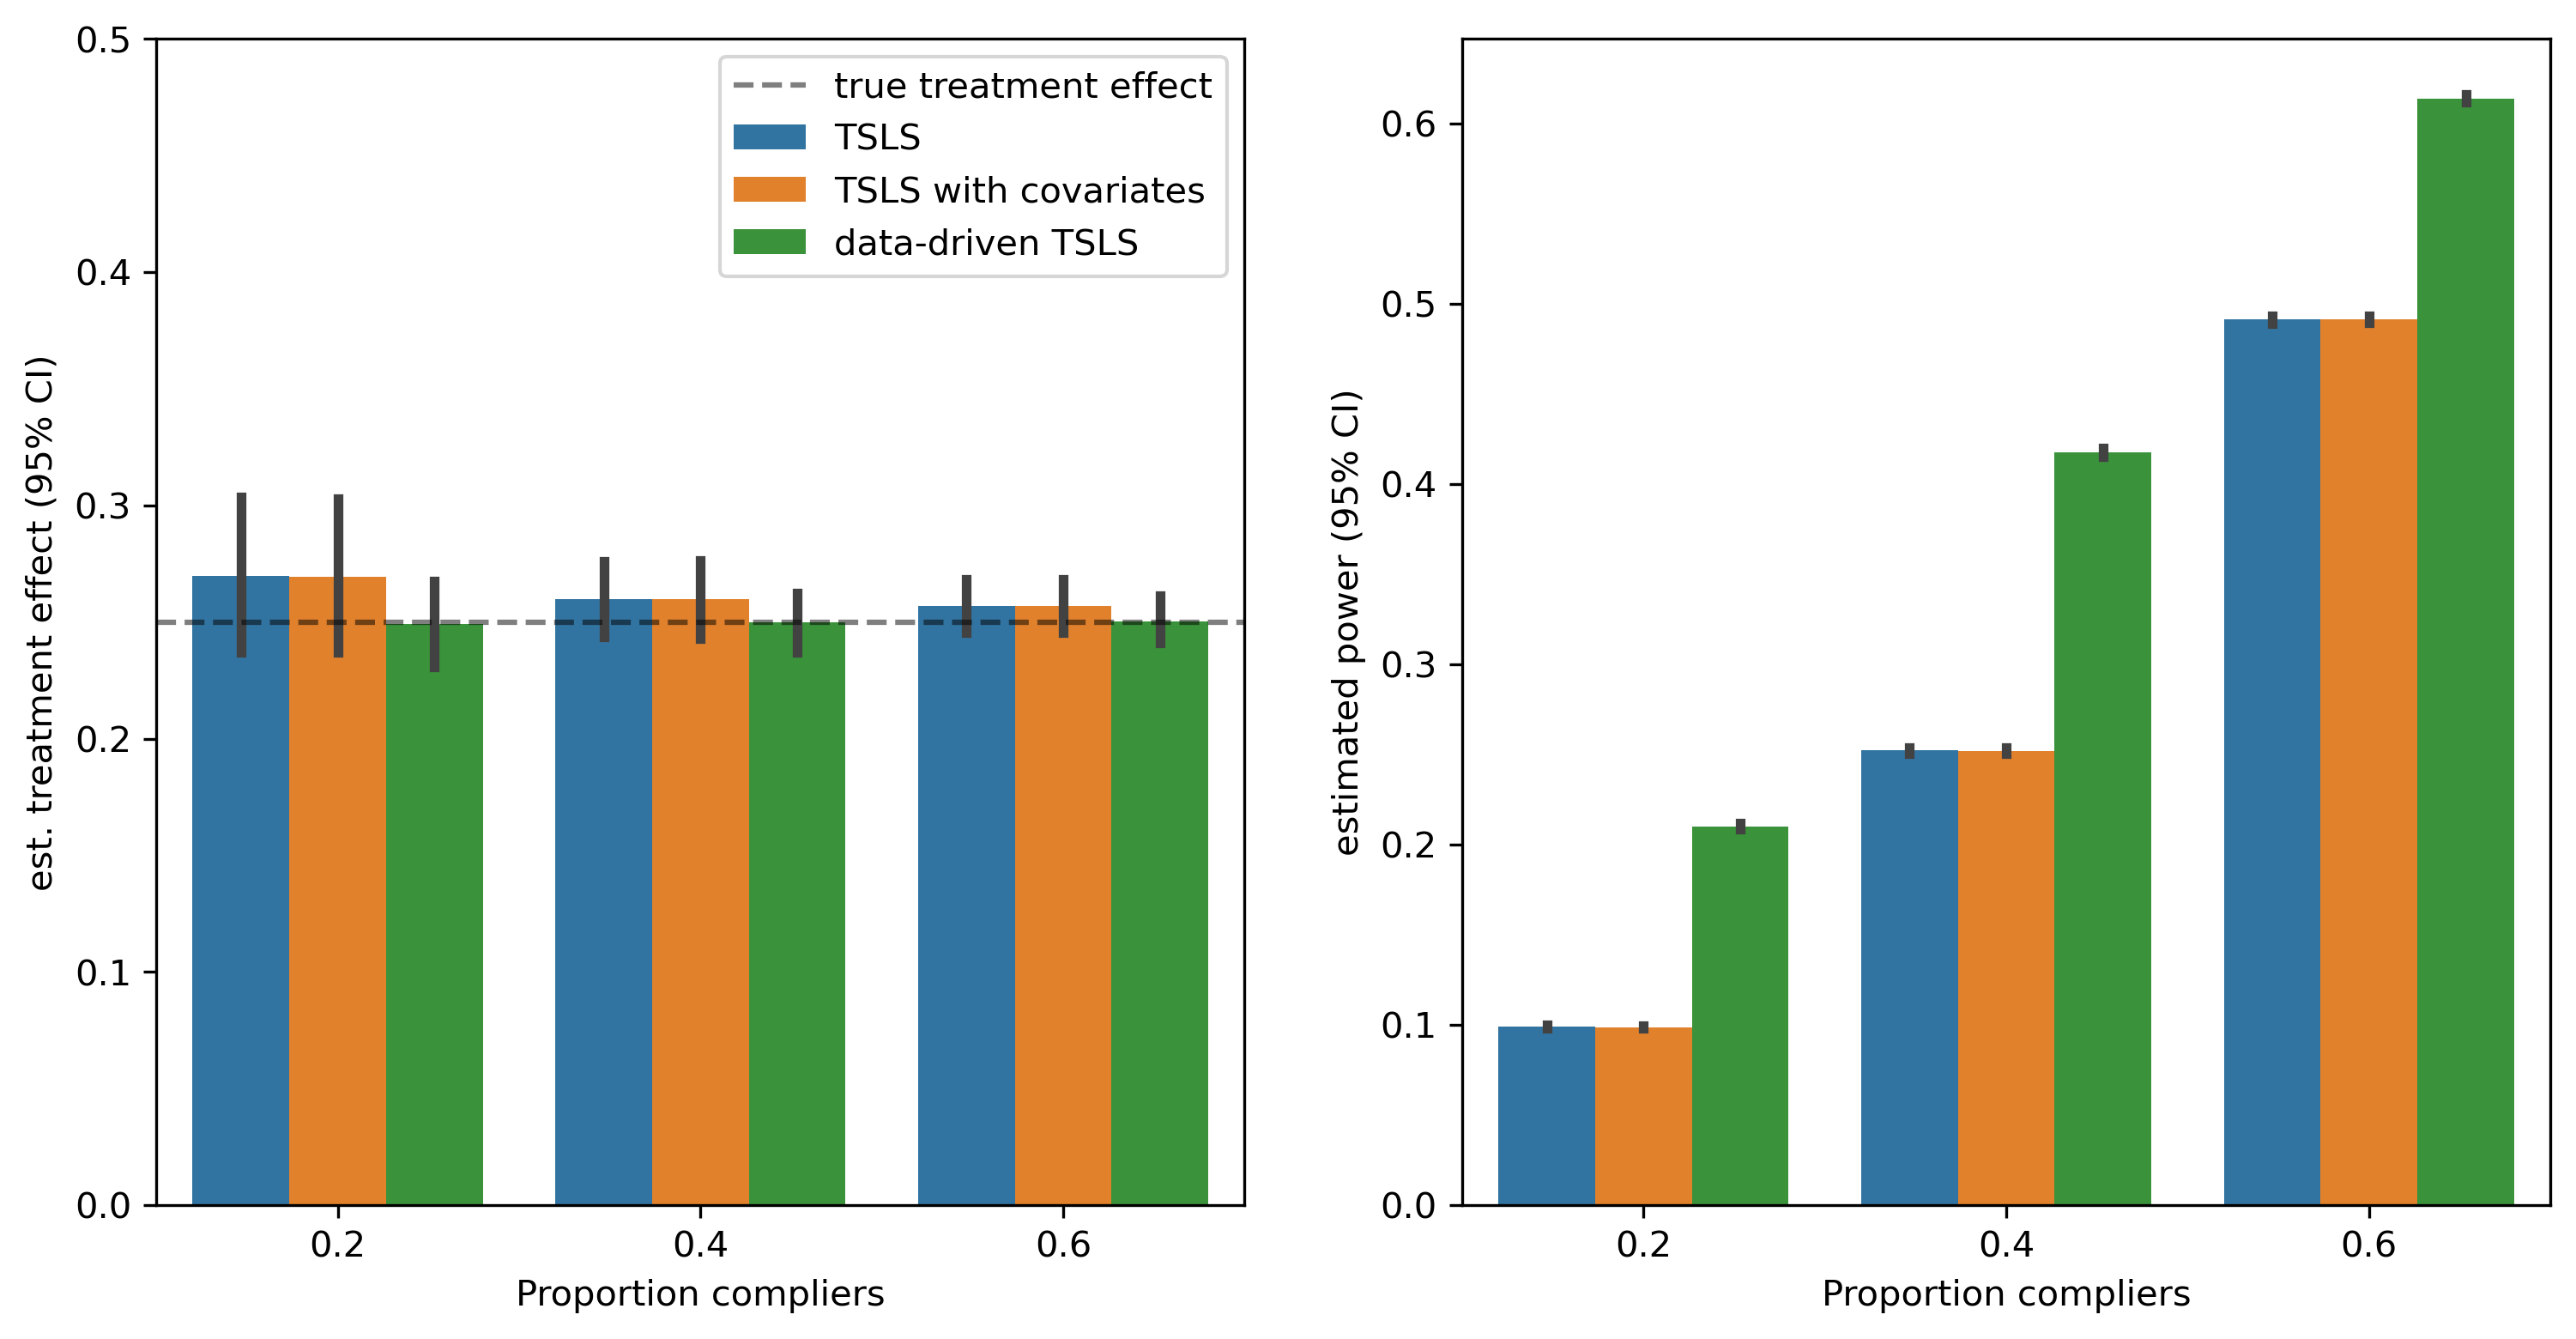

In [98]:
plot_tau_pwr(strong_out_name, tau, prop_complys)

### weak compliance prediction simulation

In [99]:
weak_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=75, 
                               n_features=5)
)

weak_out_name = "weak_comply"

In [100]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        weak_sim_dict, 
                        weak_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:220
data_df shape:382
data_df shape:602
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:163
data_df shape:280
data_df shape:443
trial 1
data_df shape:2000
data_df shape:2000
data_df shape:319
data_df shape:212
data_df shape:531
trial 2
data_df shape:2000
data_df shape:2000
data_df shape:330
data_df shape:403
data_df shape:733
trial 3
data_df shape:2000
data_df shape:2000
data_df shape:213
data_df shape:390
data_df shape:603
trial 4
data_df shape:2000
data_df shape:2000
data_df shape:372
data_df shape:168
data_df shape:540
trial 5
data_df shape:2000
data_df shape:2000
data_df shape:187
data_df shape:307
data_df shape:494
trial 6
data_df shape:2000
data_df shape:2000
data_df shape:227
data_df shape:150
data_df shape:377
trial 7
data_df shape:2000
data_df shape:2000
data_df shape:271
data_df shape:250
data_df shape:521
trial 8
data_df shape:2000
data_df shape:2000
data_df shape:231
data_df shape:18

data_df shape:2000
data_df shape:2000
data_df shape:236
data_df shape:227
data_df shape:463
trial 81
data_df shape:2000
data_df shape:2000
data_df shape:199
data_df shape:191
data_df shape:390
trial 82
data_df shape:2000
data_df shape:2000
data_df shape:249
data_df shape:300
data_df shape:549
trial 83
data_df shape:2000
data_df shape:2000
data_df shape:250
data_df shape:243
data_df shape:493
trial 84
data_df shape:2000
data_df shape:2000
data_df shape:376
data_df shape:285
data_df shape:661
trial 85
data_df shape:2000
data_df shape:2000
data_df shape:189
data_df shape:247
data_df shape:436
trial 86
data_df shape:2000
data_df shape:2000
data_df shape:165
data_df shape:225
data_df shape:390
trial 87
data_df shape:2000
data_df shape:2000
data_df shape:632
data_df shape:595
data_df shape:1227
trial 88
data_df shape:2000
data_df shape:2000
data_df shape:174
data_df shape:483
data_df shape:657
trial 89
data_df shape:2000
data_df shape:2000
data_df shape:199
data_df shape:237
data_df shape:43

data_df shape:349
data_df shape:581
trial 161
data_df shape:2000
data_df shape:2000
data_df shape:331
data_df shape:341
data_df shape:672
trial 162
data_df shape:2000
data_df shape:2000
data_df shape:413
data_df shape:331
data_df shape:744
trial 163
data_df shape:2000
data_df shape:2000
data_df shape:321
data_df shape:316
data_df shape:637
trial 164
data_df shape:2000
data_df shape:2000
data_df shape:175
data_df shape:375
data_df shape:550
trial 165
data_df shape:2000
data_df shape:2000
data_df shape:457
data_df shape:292
data_df shape:749
trial 166
data_df shape:2000
data_df shape:2000
data_df shape:395
data_df shape:183
data_df shape:578
trial 167
data_df shape:2000
data_df shape:2000
data_df shape:204
data_df shape:366
data_df shape:570
trial 168
data_df shape:2000
data_df shape:2000
data_df shape:292
data_df shape:338
data_df shape:630
trial 169
data_df shape:2000
data_df shape:2000
data_df shape:387
data_df shape:806
data_df shape:1193
trial 170
data_df shape:2000
data_df shape:20

data_df shape:2000
data_df shape:2000
data_df shape:175
data_df shape:221
data_df shape:396
trial 242
data_df shape:2000
data_df shape:2000
data_df shape:260
data_df shape:292
data_df shape:552
trial 243
data_df shape:2000
data_df shape:2000
data_df shape:242
data_df shape:294
data_df shape:536
trial 244
data_df shape:2000
data_df shape:2000
data_df shape:208
data_df shape:177
data_df shape:385
trial 245
data_df shape:2000
data_df shape:2000
data_df shape:279
data_df shape:349
data_df shape:628
trial 246
data_df shape:2000
data_df shape:2000
data_df shape:407
data_df shape:310
data_df shape:717
trial 247
data_df shape:2000
data_df shape:2000
data_df shape:216
data_df shape:280
data_df shape:496
trial 248
data_df shape:2000
data_df shape:2000
data_df shape:325
data_df shape:197
data_df shape:522
trial 249
data_df shape:2000
data_df shape:2000
data_df shape:714
data_df shape:291
data_df shape:1005
trial 250
data_df shape:2000
data_df shape:2000
data_df shape:365
data_df shape:250
data_df

data_df shape:226
data_df shape:305
data_df shape:531
trial 322
data_df shape:2000
data_df shape:2000
data_df shape:202
data_df shape:312
data_df shape:514
trial 323
data_df shape:2000
data_df shape:2000
data_df shape:340
data_df shape:172
data_df shape:512
trial 324
data_df shape:2000
data_df shape:2000
data_df shape:192
data_df shape:261
data_df shape:453
trial 325
data_df shape:2000
data_df shape:2000
data_df shape:188
data_df shape:267
data_df shape:455
trial 326
data_df shape:2000
data_df shape:2000
data_df shape:263
data_df shape:295
data_df shape:558
trial 327
data_df shape:2000
data_df shape:2000
data_df shape:280
data_df shape:175
data_df shape:455
trial 328
data_df shape:2000
data_df shape:2000
data_df shape:246
data_df shape:364
data_df shape:610
trial 329
data_df shape:2000
data_df shape:2000
data_df shape:431
data_df shape:383
data_df shape:814
trial 330
data_df shape:2000
data_df shape:2000
data_df shape:244
data_df shape:225
data_df shape:469
trial 331
data_df shape:2000

data_df shape:2000
data_df shape:2000
data_df shape:447
data_df shape:211
data_df shape:658
trial 403
data_df shape:2000
data_df shape:2000
data_df shape:274
data_df shape:213
data_df shape:487
trial 404
data_df shape:2000
data_df shape:2000
data_df shape:375
data_df shape:493
data_df shape:868
trial 405
data_df shape:2000
data_df shape:2000
data_df shape:192
data_df shape:297
data_df shape:489
trial 406
data_df shape:2000
data_df shape:2000
data_df shape:235
data_df shape:404
data_df shape:639
trial 407
data_df shape:2000
data_df shape:2000
data_df shape:336
data_df shape:405
data_df shape:741
trial 408
data_df shape:2000
data_df shape:2000
data_df shape:304
data_df shape:218
data_df shape:522
trial 409
data_df shape:2000
data_df shape:2000
data_df shape:698
data_df shape:399
data_df shape:1097
trial 410
data_df shape:2000
data_df shape:2000
data_df shape:492
data_df shape:370
data_df shape:862
trial 411
data_df shape:2000
data_df shape:2000
data_df shape:314
data_df shape:218
data_df

data_df shape:287
data_df shape:311
data_df shape:598
trial 483
data_df shape:2000
data_df shape:2000
data_df shape:239
data_df shape:214
data_df shape:453
trial 484
data_df shape:2000
data_df shape:2000
data_df shape:511
data_df shape:318
data_df shape:829
trial 485
data_df shape:2000
data_df shape:2000
data_df shape:284
data_df shape:291
data_df shape:575
trial 486
data_df shape:2000
data_df shape:2000
data_df shape:248
data_df shape:205
data_df shape:453
trial 487
data_df shape:2000
data_df shape:2000
data_df shape:267
data_df shape:248
data_df shape:515
trial 488
data_df shape:2000
data_df shape:2000
data_df shape:290
data_df shape:262
data_df shape:552
trial 489
data_df shape:2000
data_df shape:2000
data_df shape:211
data_df shape:227
data_df shape:438
trial 490
data_df shape:2000
data_df shape:2000
data_df shape:496
data_df shape:584
data_df shape:1080
trial 491
data_df shape:2000
data_df shape:2000
data_df shape:192
data_df shape:258
data_df shape:450
trial 492
data_df shape:200

data_df shape:2000
data_df shape:2000
data_df shape:516
data_df shape:513
data_df shape:1029
trial 64
data_df shape:2000
data_df shape:2000
data_df shape:560
data_df shape:523
data_df shape:1083
trial 65
data_df shape:2000
data_df shape:2000
data_df shape:528
data_df shape:571
data_df shape:1099
trial 66
data_df shape:2000
data_df shape:2000
data_df shape:558
data_df shape:497
data_df shape:1055
trial 67
data_df shape:2000
data_df shape:2000
data_df shape:474
data_df shape:705
data_df shape:1179
trial 68
data_df shape:2000
data_df shape:2000
data_df shape:506
data_df shape:720
data_df shape:1226
trial 69
data_df shape:2000
data_df shape:2000
data_df shape:854
data_df shape:627
data_df shape:1481
trial 70
data_df shape:2000
data_df shape:2000
data_df shape:566
data_df shape:564
data_df shape:1130
trial 71
data_df shape:2000
data_df shape:2000
data_df shape:472
data_df shape:589
data_df shape:1061
trial 72
data_df shape:2000
data_df shape:2000
data_df shape:520
data_df shape:515
data_df 

data_df shape:448
data_df shape:657
data_df shape:1105
trial 144
data_df shape:2000
data_df shape:2000
data_df shape:722
data_df shape:435
data_df shape:1157
trial 145
data_df shape:2000
data_df shape:2000
data_df shape:561
data_df shape:694
data_df shape:1255
trial 146
data_df shape:2000
data_df shape:2000
data_df shape:506
data_df shape:380
data_df shape:886
trial 147
data_df shape:2000
data_df shape:2000
data_df shape:508
data_df shape:474
data_df shape:982
trial 148
data_df shape:2000
data_df shape:2000
data_df shape:426
data_df shape:646
data_df shape:1072
trial 149
data_df shape:2000
data_df shape:2000
data_df shape:526
data_df shape:569
data_df shape:1095
trial 150
data_df shape:2000
data_df shape:2000
data_df shape:471
data_df shape:383
data_df shape:854
trial 151
data_df shape:2000
data_df shape:2000
data_df shape:491
data_df shape:471
data_df shape:962
trial 152
data_df shape:2000
data_df shape:2000
data_df shape:542
data_df shape:500
data_df shape:1042
trial 153
data_df shap

data_df shape:409
data_df shape:423
data_df shape:832
trial 224
data_df shape:2000
data_df shape:2000
data_df shape:462
data_df shape:487
data_df shape:949
trial 225
data_df shape:2000
data_df shape:2000
data_df shape:456
data_df shape:601
data_df shape:1057
trial 226
data_df shape:2000
data_df shape:2000
data_df shape:334
data_df shape:433
data_df shape:767
trial 227
data_df shape:2000
data_df shape:2000
data_df shape:767
data_df shape:690
data_df shape:1457
trial 228
data_df shape:2000
data_df shape:2000
data_df shape:425
data_df shape:467
data_df shape:892
trial 229
data_df shape:2000
data_df shape:2000
data_df shape:429
data_df shape:627
data_df shape:1056
trial 230
data_df shape:2000
data_df shape:2000
data_df shape:424
data_df shape:422
data_df shape:846
trial 231
data_df shape:2000
data_df shape:2000
data_df shape:553
data_df shape:498
data_df shape:1051
trial 232
data_df shape:2000
data_df shape:2000
data_df shape:608
data_df shape:436
data_df shape:1044
trial 233
data_df shape

data_df shape:556
data_df shape:407
data_df shape:963
trial 304
data_df shape:2000
data_df shape:2000
data_df shape:521
data_df shape:457
data_df shape:978
trial 305
data_df shape:2000
data_df shape:2000
data_df shape:447
data_df shape:483
data_df shape:930
trial 306
data_df shape:2000
data_df shape:2000
data_df shape:568
data_df shape:596
data_df shape:1164
trial 307
data_df shape:2000
data_df shape:2000
data_df shape:669
data_df shape:535
data_df shape:1204
trial 308
data_df shape:2000
data_df shape:2000
data_df shape:419
data_df shape:514
data_df shape:933
trial 309
data_df shape:2000
data_df shape:2000
data_df shape:513
data_df shape:666
data_df shape:1179
trial 310
data_df shape:2000
data_df shape:2000
data_df shape:448
data_df shape:484
data_df shape:932
trial 311
data_df shape:2000
data_df shape:2000
data_df shape:470
data_df shape:559
data_df shape:1029
trial 312
data_df shape:2000
data_df shape:2000
data_df shape:400
data_df shape:522
data_df shape:922
trial 313
data_df shape:

data_df shape:639
data_df shape:395
data_df shape:1034
trial 384
data_df shape:2000
data_df shape:2000
data_df shape:503
data_df shape:531
data_df shape:1034
trial 385
data_df shape:2000
data_df shape:2000
data_df shape:514
data_df shape:552
data_df shape:1066
trial 386
data_df shape:2000
data_df shape:2000
data_df shape:423
data_df shape:590
data_df shape:1013
trial 387
data_df shape:2000
data_df shape:2000
data_df shape:388
data_df shape:659
data_df shape:1047
trial 388
data_df shape:2000
data_df shape:2000
data_df shape:446
data_df shape:569
data_df shape:1015
trial 389
data_df shape:2000
data_df shape:2000
data_df shape:445
data_df shape:436
data_df shape:881
trial 390
data_df shape:2000
data_df shape:2000
data_df shape:506
data_df shape:559
data_df shape:1065
trial 391
data_df shape:2000
data_df shape:2000
data_df shape:534
data_df shape:536
data_df shape:1070
trial 392
data_df shape:2000
data_df shape:2000
data_df shape:621
data_df shape:502
data_df shape:1123
trial 393
data_df s

data_df shape:507
data_df shape:484
data_df shape:991
trial 464
data_df shape:2000
data_df shape:2000
data_df shape:571
data_df shape:412
data_df shape:983
trial 465
data_df shape:2000
data_df shape:2000
data_df shape:371
data_df shape:604
data_df shape:975
trial 466
data_df shape:2000
data_df shape:2000
data_df shape:470
data_df shape:540
data_df shape:1010
trial 467
data_df shape:2000
data_df shape:2000
data_df shape:596
data_df shape:469
data_df shape:1065
trial 468
data_df shape:2000
data_df shape:2000
data_df shape:653
data_df shape:607
data_df shape:1260
trial 469
data_df shape:2000
data_df shape:2000
data_df shape:381
data_df shape:429
data_df shape:810
trial 470
data_df shape:2000
data_df shape:2000
data_df shape:357
data_df shape:417
data_df shape:774
trial 471
data_df shape:2000
data_df shape:2000
data_df shape:435
data_df shape:576
data_df shape:1011
trial 472
data_df shape:2000
data_df shape:2000
data_df shape:470
data_df shape:588
data_df shape:1058
trial 473
data_df shape

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



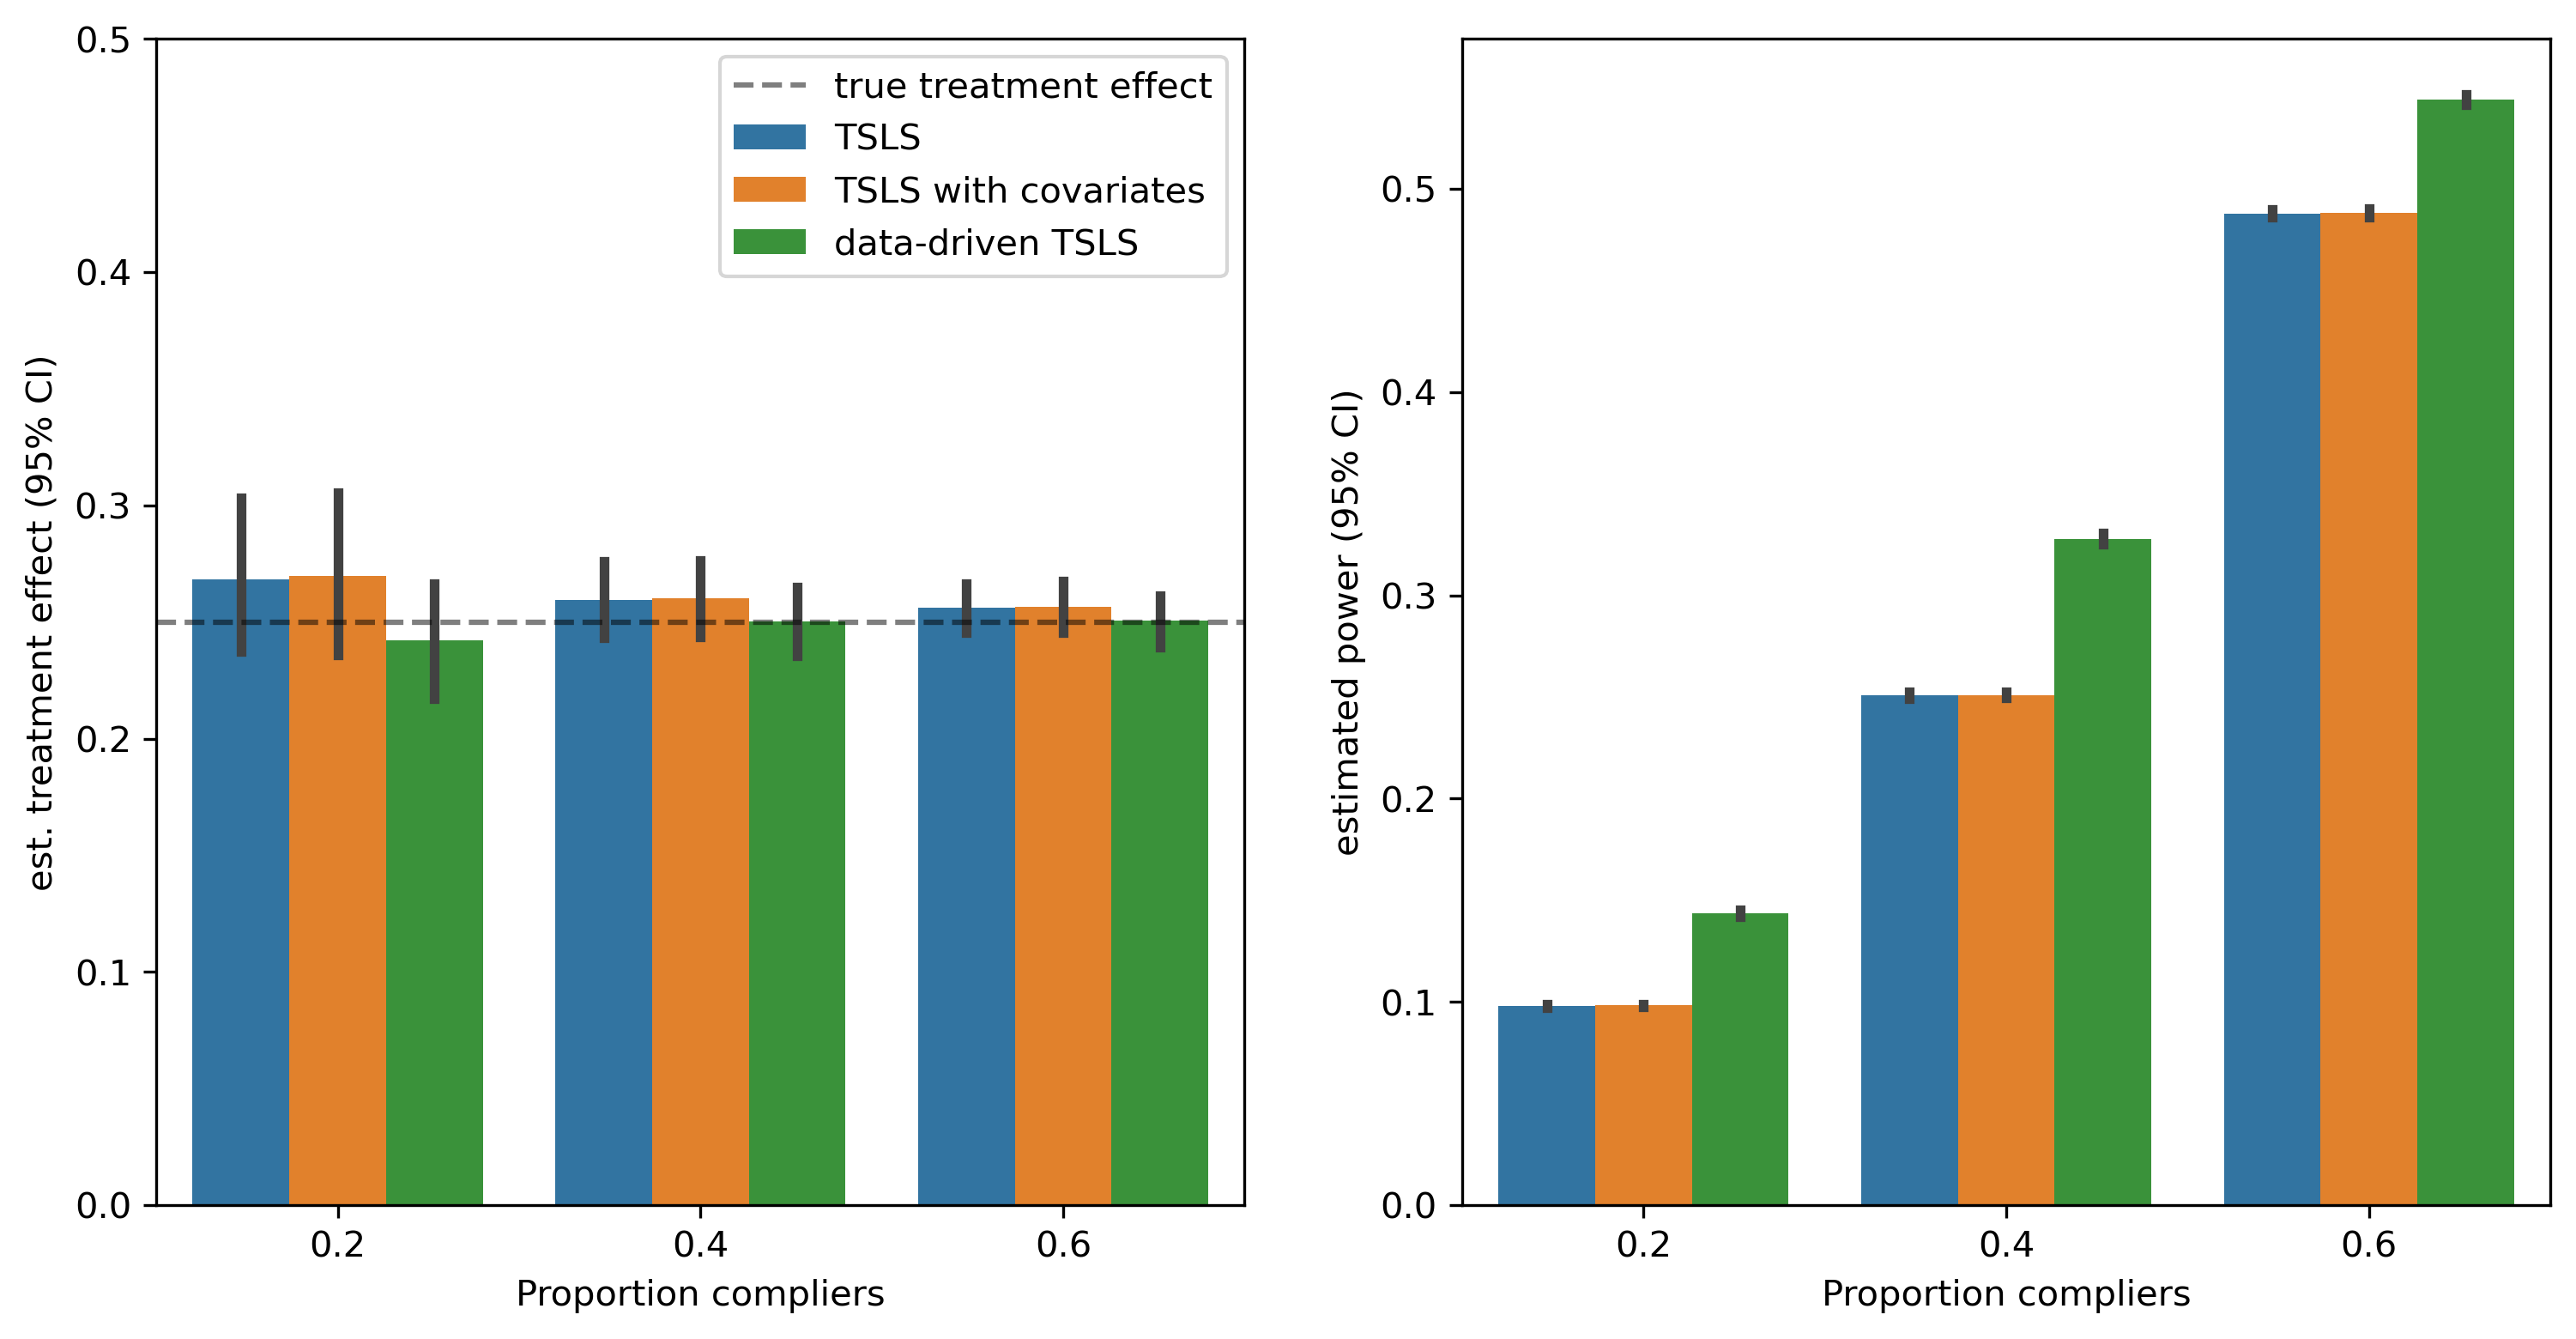

In [101]:
plot_tau_pwr(weak_out_name, tau, prop_complys)

### noise compliance prediction simulation

In [102]:
noise_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=0, 
                               noise=75, 
                               n_features=5)
)

noise_out_name = "noise_comply"

In [103]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        noise_sim_dict, 
                        noise_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:989
data_df shape:996
data_df shape:1985
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:980
data_df shape:1979
trial 1
data_df shape:2000
data_df shape:2000
data_df shape:918
data_df shape:1000
data_df shape:1918
trial 2
data_df shape:2000
data_df shape:2000
data_df shape:941
data_df shape:921
data_df shape:1862
trial 3
data_df shape:2000
data_df shape:2000
data_df shape:974
data_df shape:990
data_df shape:1964
trial 4
data_df shape:2000
data_df shape:2000
data_df shape:982
data_df shape:992
data_df shape:1974
trial 5
data_df shape:2000
data_df shape:2000
data_df shape:964
data_df shape:984
data_df shape:1948
trial 6
data_df shape:2000
data_df shape:2000
data_df shape:960
data_df shape:993
data_df shape:1953
trial 7
data_df shape:2000
data_df shape:2000
data_df shape:958
data_df shape:981
data_df shape:1939
trial 8
data_df shape:2000
data_df shape:2000
data_df shape:948
data_d

data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:966
data_df shape:1965
trial 80
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:1000
data_df shape:1996
trial 81
data_df shape:2000
data_df shape:2000
data_df shape:956
data_df shape:994
data_df shape:1950
trial 82
data_df shape:2000
data_df shape:2000
data_df shape:992
data_df shape:996
data_df shape:1988
trial 83
data_df shape:2000
data_df shape:2000
data_df shape:989
data_df shape:996
data_df shape:1985
trial 84
data_df shape:2000
data_df shape:2000
data_df shape:835
data_df shape:955
data_df shape:1790
trial 85
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:992
data_df shape:1992
trial 86
data_df shape:2000
data_df shape:2000
data_df shape:982
data_df shape:1000
data_df shape:1982
trial 87
data_df shape:2000
data_df shape:2000
data_df shape:905
data_df shape:891
data_df shape:1796
trial 88
data_df shape:2000
data_df shape:2000
data_df shape:971
data_df shape:899
data_

data_df shape:2000
data_df shape:2000
data_df shape:923
data_df shape:930
data_df shape:1853
trial 160
data_df shape:2000
data_df shape:2000
data_df shape:961
data_df shape:996
data_df shape:1957
trial 161
data_df shape:2000
data_df shape:2000
data_df shape:979
data_df shape:891
data_df shape:1870
trial 162
data_df shape:2000
data_df shape:2000
data_df shape:990
data_df shape:912
data_df shape:1902
trial 163
data_df shape:2000
data_df shape:2000
data_df shape:691
data_df shape:944
data_df shape:1635
trial 164
data_df shape:2000
data_df shape:2000
data_df shape:780
data_df shape:952
data_df shape:1732
trial 165
data_df shape:2000
data_df shape:2000
data_df shape:890
data_df shape:830
data_df shape:1720
trial 166
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:999
data_df shape:1995
trial 167
data_df shape:2000
data_df shape:2000
data_df shape:915
data_df shape:990
data_df shape:1905
trial 168
data_df shape:2000
data_df shape:2000
data_df shape:951
data_df shape:998

data_df shape:992
data_df shape:1991
trial 239
data_df shape:2000
data_df shape:2000
data_df shape:828
data_df shape:998
data_df shape:1826
trial 240
data_df shape:2000
data_df shape:2000
data_df shape:976
data_df shape:984
data_df shape:1960
trial 241
data_df shape:2000
data_df shape:2000
data_df shape:997
data_df shape:998
data_df shape:1995
trial 242
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:1000
data_df shape:1998
trial 243
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:655
data_df shape:1653
trial 244
data_df shape:2000
data_df shape:2000
data_df shape:538
data_df shape:977
data_df shape:1515
trial 245
data_df shape:2000
data_df shape:2000
data_df shape:997
data_df shape:935
data_df shape:1932
trial 246
data_df shape:2000
data_df shape:2000
data_df shape:994
data_df shape:754
data_df shape:1748
trial 247
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:902
data_df shape:1902
trial 248
data_df shape:2000
data_

data_df shape:2000
data_df shape:2000
data_df shape:982
data_df shape:983
data_df shape:1965
trial 319
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:997
data_df shape:1995
trial 320
data_df shape:2000
data_df shape:2000
data_df shape:675
data_df shape:1000
data_df shape:1675
trial 321
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:991
data_df shape:1990
trial 322
data_df shape:2000
data_df shape:2000
data_df shape:962
data_df shape:989
data_df shape:1951
trial 323
data_df shape:2000
data_df shape:2000
data_df shape:977
data_df shape:983
data_df shape:1960
trial 324
data_df shape:2000
data_df shape:2000
data_df shape:987
data_df shape:950
data_df shape:1937
trial 325
data_df shape:2000
data_df shape:2000
data_df shape:703
data_df shape:889
data_df shape:1592
trial 326
data_df shape:2000
data_df shape:2000
data_df shape:959
data_df shape:975
data_df shape:1934
trial 327
data_df shape:2000
data_df shape:2000
data_df shape:854
data_df shape:73

data_df shape:1000
data_df shape:1913
trial 398
data_df shape:2000
data_df shape:2000
data_df shape:977
data_df shape:991
data_df shape:1968
trial 399
data_df shape:2000
data_df shape:2000
data_df shape:829
data_df shape:970
data_df shape:1799
trial 400
data_df shape:2000
data_df shape:2000
data_df shape:957
data_df shape:850
data_df shape:1807
trial 401
data_df shape:2000
data_df shape:2000
data_df shape:895
data_df shape:1000
data_df shape:1895
trial 402
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:997
data_df shape:1995
trial 403
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:981
data_df shape:1980
trial 404
data_df shape:2000
data_df shape:2000
data_df shape:970
data_df shape:989
data_df shape:1959
trial 405
data_df shape:2000
data_df shape:2000
data_df shape:609
data_df shape:990
data_df shape:1599
trial 406
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:1000
data_df shape:1996
trial 407
data_df shape:2000
data

data_df shape:2000
data_df shape:2000
data_df shape:939
data_df shape:991
data_df shape:1930
trial 478
data_df shape:2000
data_df shape:2000
data_df shape:981
data_df shape:1000
data_df shape:1981
trial 479
data_df shape:2000
data_df shape:2000
data_df shape:596
data_df shape:1000
data_df shape:1596
trial 480
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:969
data_df shape:1968
trial 481
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:999
data_df shape:1999
trial 482
data_df shape:2000
data_df shape:2000
data_df shape:833
data_df shape:996
data_df shape:1829
trial 483
data_df shape:2000
data_df shape:2000
data_df shape:986
data_df shape:872
data_df shape:1858
trial 484
data_df shape:2000
data_df shape:2000
data_df shape:846
data_df shape:960
data_df shape:1806
trial 485
data_df shape:2000
data_df shape:2000
data_df shape:802
data_df shape:988
data_df shape:1790
trial 486
data_df shape:2000
data_df shape:2000
data_df shape:980
data_df shape:

data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:991
data_df shape:1991
trial 58
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:996
data_df shape:1992
trial 59
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:972
data_df shape:1971
trial 60
data_df shape:2000
data_df shape:2000
data_df shape:982
data_df shape:996
data_df shape:1978
trial 61
data_df shape:2000
data_df shape:2000
data_df shape:995
data_df shape:983
data_df shape:1978
trial 62
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:999
data_df shape:1999
trial 63
data_df shape:2000
data_df shape:2000
data_df shape:958
data_df shape:1000
data_df shape:1958
trial 64
data_df shape:2000
data_df shape:2000
data_df shape:977
data_df shape:988
data_df shape:1965
trial 65
data_df shape:2000
data_df shape:2000
data_df shape:988
data_df shape:990
data_df shape:1978
trial 66
data_df shape:2000
data_df shape:2000
data_df shape:966
data_df shape:998
data_

data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:997
data_df shape:1997
trial 138
data_df shape:2000
data_df shape:2000
data_df shape:988
data_df shape:955
data_df shape:1943
trial 139
data_df shape:2000
data_df shape:2000
data_df shape:994
data_df shape:886
data_df shape:1880
trial 140
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:997
data_df shape:1993
trial 141
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:988
data_df shape:1988
trial 142
data_df shape:2000
data_df shape:2000
data_df shape:991
data_df shape:998
data_df shape:1989
trial 143
data_df shape:2000
data_df shape:2000
data_df shape:973
data_df shape:974
data_df shape:1947
trial 144
data_df shape:2000
data_df shape:2000
data_df shape:979
data_df shape:991
data_df shape:1970
trial 145
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:993
data_df shape:1992
trial 146
data_df shape:2000
data_df shape:2000
data_df shape:993
data_df shape:9

data_df shape:956
data_df shape:969
data_df shape:1925
trial 217
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:999
data_df shape:1999
trial 218
data_df shape:2000
data_df shape:2000
data_df shape:995
data_df shape:993
data_df shape:1988
trial 219
data_df shape:2000
data_df shape:2000
data_df shape:993
data_df shape:1000
data_df shape:1993
trial 220
data_df shape:2000
data_df shape:2000
data_df shape:990
data_df shape:998
data_df shape:1988
trial 221
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:967
data_df shape:1967
trial 222
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:999
data_df shape:1999
trial 223
data_df shape:2000
data_df shape:2000
data_df shape:993
data_df shape:994
data_df shape:1987
trial 224
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:923
data_df shape:1922
trial 225
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:990
data_df shape:1986
trial 226
data

data_df shape:2000
data_df shape:2000
data_df shape:997
data_df shape:997
data_df shape:1994
trial 297
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:992
data_df shape:1988
trial 298
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:997
data_df shape:1995
trial 299
data_df shape:2000
data_df shape:2000
data_df shape:930
data_df shape:998
data_df shape:1928
trial 300
data_df shape:2000
data_df shape:2000
data_df shape:978
data_df shape:995
data_df shape:1973
trial 301
data_df shape:2000
data_df shape:2000
data_df shape:970
data_df shape:983
data_df shape:1953
trial 302
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:982
data_df shape:1982
trial 303
data_df shape:2000
data_df shape:2000
data_df shape:941
data_df shape:993
data_df shape:1934
trial 304
data_df shape:2000
data_df shape:2000
data_df shape:993
data_df shape:1000
data_df shape:1993
trial 305
data_df shape:2000
data_df shape:2000
data_df shape:989
data_df shape:9

data_df shape:991
data_df shape:950
data_df shape:1941
trial 376
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:782
data_df shape:1780
trial 377
data_df shape:2000
data_df shape:2000
data_df shape:993
data_df shape:1000
data_df shape:1993
trial 378
data_df shape:2000
data_df shape:2000
data_df shape:861
data_df shape:998
data_df shape:1859
trial 379
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:1000
data_df shape:1998
trial 380
data_df shape:2000
data_df shape:2000
data_df shape:980
data_df shape:932
data_df shape:1912
trial 381
data_df shape:2000
data_df shape:2000
data_df shape:983
data_df shape:965
data_df shape:1948
trial 382
data_df shape:2000
data_df shape:2000
data_df shape:868
data_df shape:942
data_df shape:1810
trial 383
data_df shape:2000
data_df shape:2000
data_df shape:998
data_df shape:995
data_df shape:1993
trial 384
data_df shape:2000
data_df shape:2000
data_df shape:990
data_df shape:1000
data_df shape:1990
trial 385
data_

data_df shape:2000
data_df shape:2000
data_df shape:994
data_df shape:980
data_df shape:1974
trial 456
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:938
data_df shape:1938
trial 457
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:994
data_df shape:1993
trial 458
data_df shape:2000
data_df shape:2000
data_df shape:996
data_df shape:1000
data_df shape:1996
trial 459
data_df shape:2000
data_df shape:2000
data_df shape:989
data_df shape:997
data_df shape:1986
trial 460
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:997
data_df shape:1996
trial 461
data_df shape:2000
data_df shape:2000
data_df shape:997
data_df shape:996
data_df shape:1993
trial 462
data_df shape:2000
data_df shape:2000
data_df shape:980
data_df shape:992
data_df shape:1972
trial 463
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape:987
data_df shape:1987
trial 464
data_df shape:2000
data_df shape:2000
data_df shape:1000
data_df shape

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



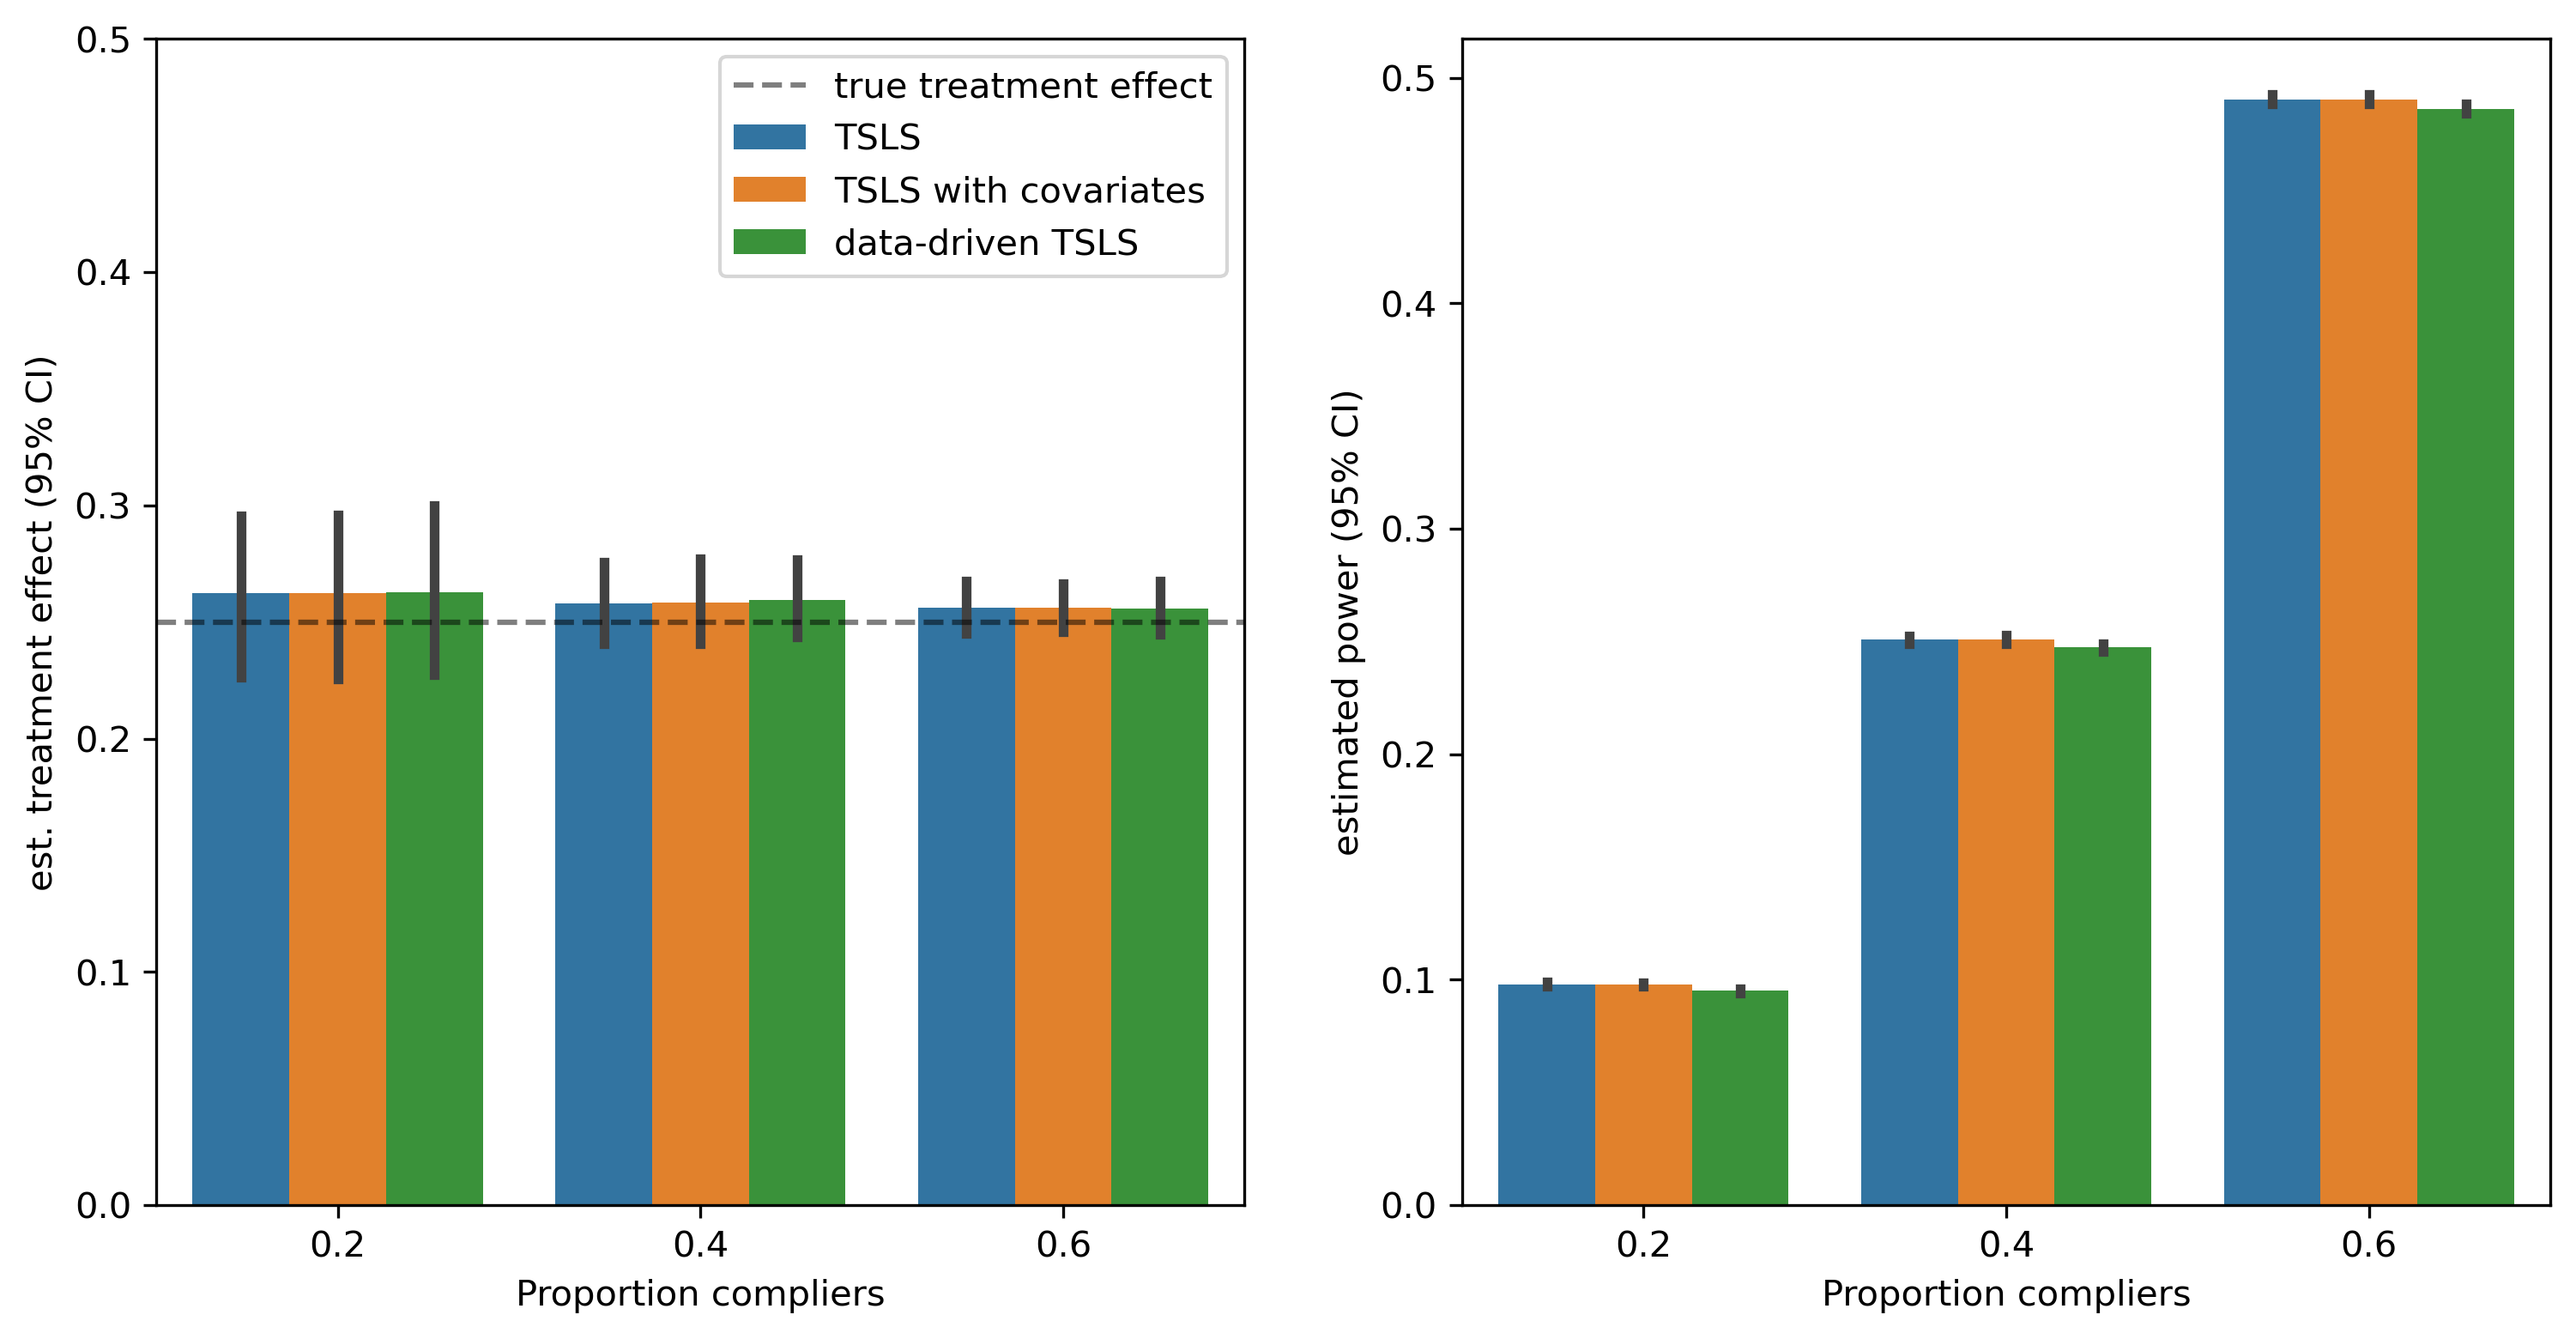

In [104]:
plot_tau_pwr(noise_out_name, tau, prop_complys)

# Custom plot for combining all 3 cases

In [3]:
tau = 0.25
n_samples = 2000
n_trials = 500
prop_complys = [0.2, 0.4, 0.6]

In [4]:
result_dict = {}
for data_name in ['strong_comply', 'weak_comply', 'noise_comply']:
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in prop_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)
    
    result_dict[data_name] = all_df

In [6]:
fig, (tau_axes, pwr_axes) = plt.subplots(2,3, figsize=(16,8), dpi=300)
x_var = 'Proportion compliers'

plt.rcParams.update({
    "text.usetex": True,
})

for idx, data_name in enumerate(['strong_comply', 'weak_comply', 'noise_comply']):
    
    cur_df = result_dict[data_name]
    
    tau_hats = pd.melt(cur_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                              'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(cur_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                          'pwr_s1_s2_simple'])

    # tau plotting
    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=tau_axes[idx])
    tau_axes[idx].axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    tau_axes[idx].set_ylim(0,0.5)
    tau_axes[idx].set_ylabel("")
    tau_axes[idx].set_xlabel("")
    if idx > 0:
        tau_axes[idx].get_legend().remove()

    
    # pwr plotting
    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=pwr_axes[idx])
    pwr_axes[idx].set_ylim(0,0.7)
    pwr_axes[idx].set_ylabel("")
    pwr_axes[idx].set_xlabel("")
    pwr_axes[idx].get_legend().remove()
    
tau_axes[0].set_ylabel("est. treatment effect (95% CI)")
pwr_axes[0].set_ylabel("estimated power (95% CI)")

pwr_axes[0].set_xlabel("$p_\text{comply}$\n\nCovariates strongly predict compliance")
pwr_axes[1].set_xlabel("Proportion compliers\n\nCovariates weakly predict compliance")
pwr_axes[2].set_xlabel("Proportion compliers\n\nCovariates do not predict compliance")


handles, labels = tau_axes[0].get_legend_handles_labels()
new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
tau_axes[0].legend(handles, new_labels)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff7a037fd40> (for post_execute):


RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/home/tliu/.cache/matplotlib/tex.cache/6be67e2d9c3c0e0576f96f57d2840f89.dvi: No such file or directory
This is dvipng 1.14 Copyright 2002-2010 Jan-Ake Larsson




RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/home/tliu/.cache/matplotlib/tex.cache/6be67e2d9c3c0e0576f96f57d2840f89.dvi: No such file or directory
This is dvipng 1.14 Copyright 2002-2010 Jan-Ake Larsson




<Figure size 4800x2400 with 6 Axes>

In [ ]:
tau_hats = pd.melt(all_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                      'tau_hat_s1_s2_simple'])
pwrs = pd.melt(all_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                  'pwr_s1_s2_simple'])

    fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,6))
    # reproduces NACI paper figure
    #fig, (ax1, ax2) = plt.subplots(1,2, dpi=100, figsize=(10,6))

    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=ax1)
    ax1.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    ax1.set_ylabel("est. treatment effect (95% CI)")
    ax1.set_ylim(0,0.5)


    handles, labels = ax1.get_legend_handles_labels()
    new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
    #ax1.legend(handles, new_labels, bbox_to_anchor=(2.9,1))
    ax1.legend(handles, new_labels)
    #ax1.set_xlabel("Proportion compliers ")
    #ax1.set_title("Treatment effect estimates")
    # sns.barplot(data=std_errs, hue="variable", x='P(treat) jump', y="value", ax=ax2)
    # ax2.set_ylabel("standard errors")
    # ax2.get_legend().set_visible(False)

    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=ax2)#, estimator=median)
    #ax2.set_title("Statistical power")
    ax2.set_ylabel("estimated power (95% CI)")
    ax2.get_legend().set_visible(False)
    #ax2.set_xlabel("Proportion compliers (95% CI)")

# Sandbox

## Custom GridSearchCV

In [76]:
from sklearn.metrics import make_scorer

In [118]:
def iv_neff_score(y, y_pred, data=None):
    """
    Computes the effective sample size of the given data sample.
    
    Args:
        y (np.array): defined to match the function signature of a score, not used. 
        y_pred (np.array): binary indicator of whether a sample is included (1) or excluded (0)
        data (pd.DataFrame): the data frame containing T and Z
    
    """    
    data['sel'] = y_pred
    #print(data)
    sel_df = data[data['sel'] == 1].copy()
    
    comply_rate = sel_df[(sel_df['Z'] == 1)]['T'].mean() - sel_df[(sel_df['Z'] == 0)]['T'].mean()
    
    return sel_df.shape[0] * (comply_rate**2)

In [120]:
neff_scorer = make_scorer(iv_neff_score)

In [89]:
class ExcludeClassifier(CausalForest):
    """
    Wrapper class for CausalForest, with a threshold.
    
    TODO modify so that y actually contains both Z and T, which can then be passed into scorer as "y"
    "y_pred" should still be allowed as a single score.
    """
    def __init__(self, threshold=0.5, n_estimators=100):
        self.threshold = threshold
        super().__init__(n_estimators=n_estimators)
    
    def fit(self, X, y):
        """
        Here, to hack around the sklearn API, y is actually a df with 'T' and 'Z' values.
        """
        super().fit(X, T, y)
    
    def predict(self, X):
        preds = super().predict(X)
        
        return preds > self.threshold

In [53]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [54]:

X = s1_df[feat_cols]
Y = s1_df['T'].values
T = s1_df['Z'].values

In [95]:
cforest = ExcludeClassifier()
cforest_cv = GridSearchCV(estimator=cforest,
                          param_grid={
                              "n_estimators": [100],
                              "threshold": [0.5, 0.7, 0.8]
                          },
                          scoring="accuracy", 
                          verbose=4)

In [96]:
%%time
cforest_cv.fit(X=X, y=Y, T=T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...n_estimators=100, threshold=0.5;, score=0.570 total time=   0.4s
[CV 2/5] END ...n_estimators=100, threshold=0.5;, score=0.555 total time=   0.3s
[CV 3/5] END ...n_estimators=100, threshold=0.5;, score=0.565 total time=   0.3s
[CV 4/5] END ...n_estimators=100, threshold=0.5;, score=0.475 total time=   0.3s
[CV 5/5] END ...n_estimators=100, threshold=0.5;, score=0.570 total time=   0.3s
[CV 1/5] END ...n_estimators=100, threshold=0.7;, score=0.510 total time=   0.3s
[CV 2/5] END ...n_estimators=100, threshold=0.7;, score=0.485 total time=   0.3s
[CV 3/5] END ...n_estimators=100, threshold=0.7;, score=0.555 total time=   0.3s
[CV 4/5] END ...n_estimators=100, threshold=0.7;, score=0.455 total time=   0.3s
[CV 5/5] END ...n_estimators=100, threshold=0.7;, score=0.515 total time=   0.3s
[CV 1/5] END ...n_estimators=100, threshold=0.8;, score=0.500 total time=   0.3s
[CV 2/5] END ...n_estimators=100, threshold=0.8;,

GridSearchCV(estimator=ExcludeClassifier(),
             param_grid={'n_estimators': [100], 'threshold': [0.5, 0.7, 0.8]},
             scoring='accuracy', verbose=4)

In [97]:
cforest_cv.best_params_

{'n_estimators': 100, 'threshold': 0.5}